# Оценка риска ДТП

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, make_scorer, \
                            f1_score, fbeta_score, average_precision_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42

## 1. Подключение к базе данных

In [2]:
db_config = {
            'user': '***', # имя пользователя,
            'pwd': '***', # пароль,
            'host': '***',
            'port': 1111, # порт подключения,
            'db': '***' # название базы данных,
} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                       db_config['pwd'],
                                                       db_config['host'],
                                                       db_config['port'],
                                                       db_config['db'])

In [3]:
engine = create_engine(connection_string)

## 2. Первичное исследование таблиц

In [4]:
query = '''
SELECT *
FROM collisions
LIMIT 3;
'''
query_2 = '''
SELECT COUNT(*),
       COUNT(DISTINCT case_id) AS unique
FROM collisions;
'''
display(pd.read_sql_query(sql=query, con=engine))
pd.read_sql_query(sql=query_2, con=engine)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


,count,unique
0,1400000,1400000


В таблице `collisions` 1.4 млн уникальных записей о ДТП. О каждой аварии известно место, время, погодные условия, состояние дороги, количество участников, причина аварии, как и с чем столкнулся автомобиль. В описании базы столбец `control_device` называется по другому. В столбцах `intersection` и `location_type` находятся похожие данные - тип места аварии.

In [5]:
query = '''
SELECT  intersection,
        location_type,
        COUNT(*)
FROM collisions
GROUP BY intersection, location_type
;
'''
display(pd.read_sql_query(sql=query, con=engine))

,intersection,location_type,count
0,0.0,highway,409483
1,0.0,intersection,7605
2,0.0,ramp,62306
3,0.0,None,596263
4,1.0,highway,6252
5,1.0,intersection,18916
6,1.0,ramp,12916
7,1.0,None,274040
8,NaN,highway,796
9,NaN,intersection,135


Перекресток не всегда совпадает с локацией - иногда шоссе в `location_type` помечены перекрестками в `intersection`.

In [6]:
query = '''
SELECT *
FROM parties
LIMIT 3;
'''
query_2 = '''
SELECT COUNT(case_id),
       COUNT(DISTINCT case_id) AS unique
FROM parties
;
'''
display(pd.read_sql_query(sql=query, con=engine))
pd.read_sql_query(sql=query_2, con=engine)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29,had not been drinking,None,0
1,23,3899454,2,road signs,0,7,had not been drinking,None,0
2,29,3899462,2,car,0,21,had not been drinking,None,0


,count,unique
0,2752408,1400000


В таблице `parties` 1.4 млн уникальных записей, такое же количество как в `collisions`. Всего 2.75 млн записей об участниках ДТП. Есть информация о типе участника, его номере, страховке, трезвости, физическом состоянии и  пользовании телефоном во время поездки.

In [7]:
query = '''
SELECT *
FROM vehicles
LIMIT 3;
'''
query_2 = '''
SELECT COUNT(case_id),
       COUNT(DISTINCT case_id) AS unique
FROM vehicles;
'''
display(pd.read_sql_query(sql=query, con=engine))
pd.read_sql_query(sql=query_2, con=engine)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3


,count,unique
0,1021234,792642


В таблице `vehicles` данные об авто, участвовавших в аварии. Всего 1.02 млн записей о машинах и 792.6 тыс уникальных записей о ДТП. Известен тип машины, коробка передач и возраст.

In [8]:
query = '''
SELECT *
FROM parties
JOIN vehicles ON parties.case_id = vehicles.case_id
     AND parties.party_number = vehicles.party_number
ORDER BY parties.case_id
LIMIT 3
;
'''
pd.read_sql_query(sql=query, con=engine)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,4,3858022,1,car,1,47,impairment unknown,G,NaN,1,3858022,1,sedan,auto,3
1,17,3899450,1,car,0,72,had not been drinking,None,0.0,3,3899450,1,coupe,auto,11
2,21,3899453,3,car,0,42,had not been drinking,None,0.0,5,3899453,3,sedan,manual,10


Все таблицы можно связать по общему ключу `case_id`. `party_number` вместе с `case_id` служит ключем для связи таблиц `parties` и `vehicles`.

## 3. Статистический анализ факторов ДТП

Для лучшего понимания данных нужно провести их анализ. Составлю несколько задач.

- В какие месяцы происходит наибольшее количество аварий?
- Как возраст автомобиля влияет на риск стать виновником ДТП?
- Влияет ли сумма страховки на аккуратность вождения и риск попасть в ДТП?
- Как часто водители под влиянием алкоголя или лекарств становятся виновниками ДТП?
- Как связана серьезность повреждения авто и трезвость водителя?
- Какой процент ДТП происходит на дорогах в плохом состоянии?
- Какой процент аварий происходит при плохом освещении?
- Как часто водитель не виноват в ДТП?

#### В какие месяцы происходит наибольшее количество аварий?

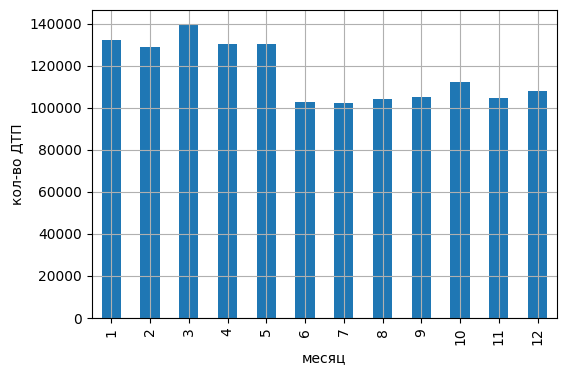

In [9]:
query = '''
SELECT CAST(EXTRACT('MONTH' FROM collision_date) AS int) AS collision_month,
       COUNT(case_id)
FROM collisions
GROUP BY CAST(EXTRACT('MONTH' FROM collision_date) AS int);
'''
pd.read_sql_query(sql=query, con=engine).plot(x='collision_month', y='count', kind='bar', figsize=(6, 4),\
                                              xlabel='месяц', ylabel='кол-во ДТП', legend='', grid=True);

ДТП происходят чаще всего с января по май, в эти месяцы их от 130 до 140 тыс. Самое большое количество аварий - в марте.  В остальные месяцы - от 102 до 112 тыс. Наименьшее количество аварий происходит летом.

In [10]:
# новый код
query = '''
SELECT CAST(EXTRACT('YEAR' FROM collision_date) AS int) AS collision_year,
       COUNT(case_id)
FROM collisions
GROUP BY CAST(EXTRACT('YEAR' FROM collision_date) AS int);
'''
pd.read_sql_query(sql=query, con=engine).T

,0,1,2,3,4,5
collision_year,2009,2010,2011,2012,2013,2020
count,426228,416490,402428,154547,305,2


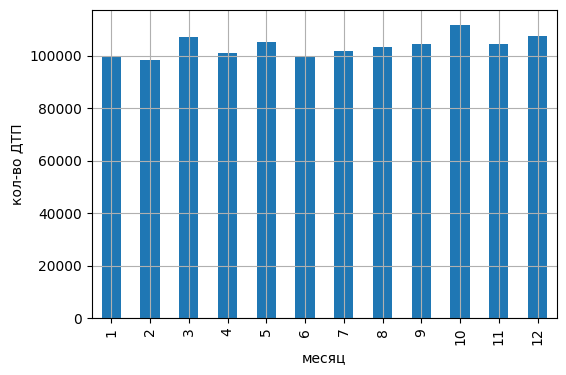

In [11]:
# новый код
query = '''
SELECT CAST(EXTRACT('MONTH' FROM collision_date) AS int) AS collision_month,
       COUNT(case_id)
FROM collisions
WHERE CAST(EXTRACT('YEAR' FROM collision_date) AS int) < 2012
GROUP BY CAST(EXTRACT('MONTH' FROM collision_date) AS int);
'''
pd.read_sql_query(sql=query, con=engine).plot(x='collision_month', y='count', kind='bar', figsize=(6, 4),\
                                              xlabel='месяц', ylabel='кол-во ДТП', legend='', grid=True);

#### Как возраст автомобиля влияет на риск стать виновником ДТП?

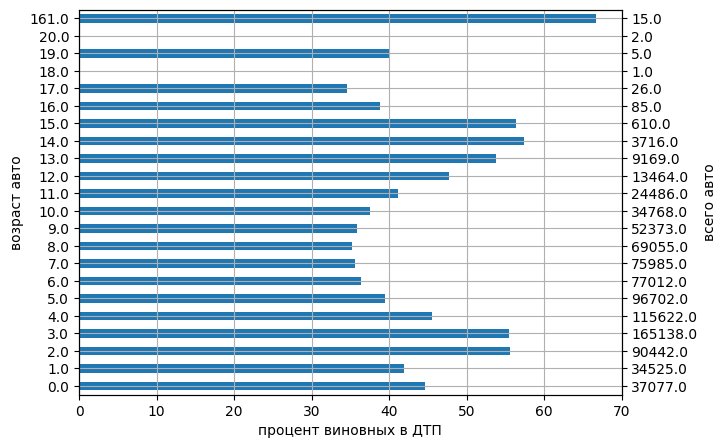

In [12]:
query = '''
WITH
age_fault AS (
    SELECT vehicle_age,
           at_fault,
           COUNT(*)
    FROM vehicles as v
    JOIN parties as p ON v.case_id = p.case_id AND v.party_number = p.party_number
    WHERE party_type = 'car'
    GROUP BY vehicle_age, at_fault)

SELECT af.vehicle_age,
       af.at_fault,
       SUM(count) OVER (PARTITION BY vehicle_age),
       count / SUM(count) OVER (PARTITION BY vehicle_age) * 100 AS fault_percent
FROM age_fault AS af
;
'''
df = pd.read_sql_query(sql=query, con=engine).dropna().pivot(index=['vehicle_age'], columns=['at_fault'],\
                                                             values=['fault_percent', 'sum'])
ax = df.plot(y=('fault_percent', 1), kind='barh', figsize=(7, 5), legend='', grid=True,\
             xlabel='процент виновных в ДТП', ylabel='возраст авто')
ax2 = ax.twinx(); ax2.set_ylim(ax.get_ylim()); ax2.set_ylabel('всего авто')
ax2.set_yticks(np.arange(len(df['sum', 0])), labels=df['sum', 0]);

В данные попали 15 авто с возрастом 161 год - должно быть какая-то ошибка. Также машин старше 15 лет очень мало, анализировать их не будем.       

Прямой зависимости, вроде "чем старше машина, тем больше риск устроить ДТП" нет. У машин возрастом 14 лет самый большой процент виновных в ДТП водителей - около 57%, чуть меньше процент у 15-летних машин. У авто 2- и 3-летней давности 55% водителей создают ДТП.      
Водители новеньких и еще не совсем старых машин реже всего становятся виновниками ДТП - у машин возрастом 5-10 лет в среднем всего в 37% случаев, у машин возрастом год и меньше - в среднем в 43% случаев.         
Может, такая статистика связана с техническим состоянием машин определенного возраста, или с общей надежностью машин определенного года выпуска. Или, может, водители больше заботятся о своих авто когда только приобрели или уже "знакомы" с ними. В любом случае, для каршеринга больше смысла смотреть на состояние авто или стаж водителя, чем просто на возраст авто.

#### Влияет ли сумма страховки на аккуратность вождения и риск попасть в ДТП?

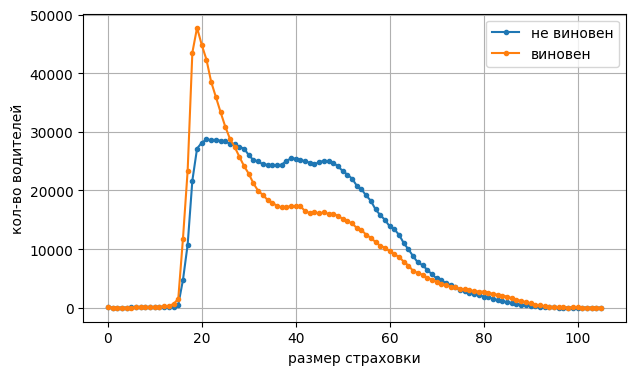

In [13]:
query = '''
SELECT insurance_premium,
       at_fault, 
       COUNT(at_fault)
FROM parties
WHERE party_type = 'car'
GROUP BY insurance_premium, at_fault
ORDER BY at_fault, insurance_premium;
'''
df = pd.read_sql_query(sql=query, con=engine)
ax = df[df['at_fault'] == 0].plot(x='insurance_premium', y='count', label='не виновен', style='.-');
df[df['at_fault'] == 1].plot(x='insurance_premium', y='count', label='виновен', grid=True,\
                             ax=ax, xlabel='размер страховки', ylabel='кол-во водителей', figsize=(7, 4), style='.-');
plt.show()

Большинство водителей страхуют свои авто на сумму от 16 до 65 тысяч. Водители со страховкой меньше 30 тыс гораздо чаще оказываются виновны в ДТП. От 30 до 65 тыс наоборот - чаще невиновны. Редко кто страхует машину на сумму больше 80 тыс, но водители, кто все же это сделал, немного чаще устраивают аварии, чем просто попадают в них.
Виновниками ДТП чаще всего становились водители, застраховавшие свои авто на сумму 18-20 тыс. В этом же диапазоне самое большое соотношение виновных к невиновным - в среднем 46000 к 25000. Самый "безопасный" диапазон  это 42-45 тыс - в среднем на 16000 виновных водителей приходится 25000 невиновных.

В каршеринге размер страховки машины водитель, скорее всего, знать не будет. Насколько аккуратно водитель будет обращаться с машиной из парка нужно изучать на данных об этих машинах, а данные про страховку вряд ли сделают предсказания модели точнее.

#### Как часто водители под влиянием алкоголя или лекарств становятся виновниками ДТП?

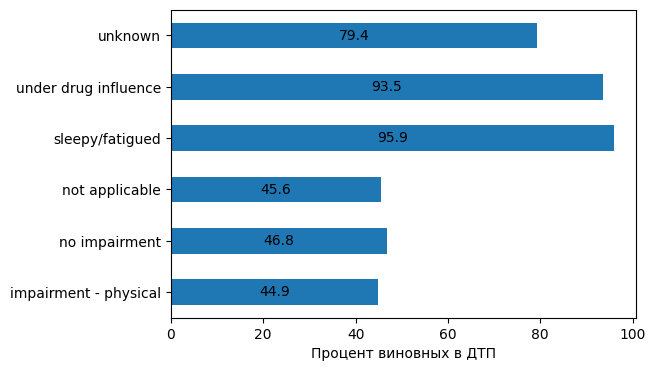

In [14]:
query = '''
WITH 
drug_count AS (
    SELECT CASE
                WHEN party_drug_physical IS NULL THEN 'no impairment'
                WHEN party_drug_physical = 'G' THEN 'unknown'
                ELSE party_drug_physical
           END,
           at_fault, 
           COUNT(*) 
    FROM parties
    WHERE party_type = 'car'
    GROUP BY party_drug_physical, at_fault)

SELECT *,
       100 - LAG(count) OVER (PARTITION BY party_drug_physical) /
               SUM(count) OVER (PARTITION BY party_drug_physical) * 100 AS drug_percent
FROM drug_count
;'''
ax = pd.read_sql_query(sql=query, con=engine).dropna().plot(x='party_drug_physical', y='drug_percent', kind='barh',
                                                       figsize=(6, 4), ylabel='', xlabel='Процент виновных в ДТП', legend='');
ax.bar_label(ax.containers[0], fmt='%.1f', label_type='center');

Уставшие или сонные водители устраивают ДТП чаще всего - в почти 96% случаев. Водители под действием лекарств - в 93.5% случаев. Самый маленький процент виновных в ДТП, почему-то, у водителей с каким-либо физическим ограничением - всего 44.9%. Среди водителей в нормальном состоянии ДТП устроили только 46.8%.

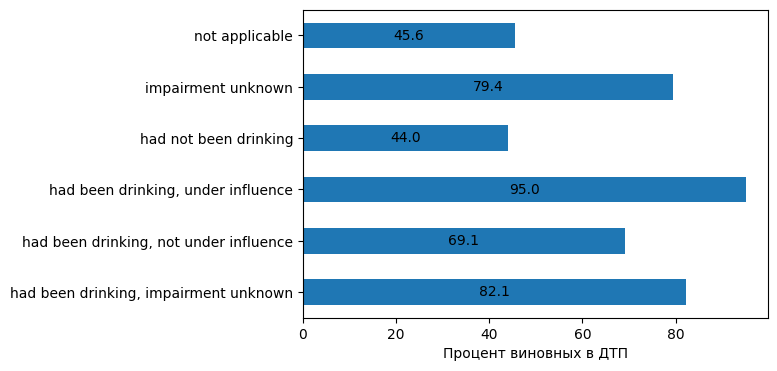

In [15]:
query = '''
WITH 
sober_count AS (
    SELECT party_sobriety,
           at_fault, 
           COUNT(*) 
    FROM parties
    WHERE party_type = 'car'
    GROUP BY party_sobriety, at_fault)

SELECT *,
       100 - LAG(count) OVER (PARTITION BY party_sobriety) /
               SUM(count) OVER (PARTITION BY party_sobriety) * 100 AS sober_percent
FROM sober_count
;'''
ax = pd.read_sql_query(sql=query, con=engine).dropna().plot(x='party_sobriety', y='sober_percent', kind='barh',
                                                       figsize=(6, 4), ylabel='', xlabel='Процент виновных в ДТП', legend='');
ax.bar_label(ax.containers[0], fmt='%.1f', label_type='center');

Если нетрезвый водитель сел за руль и произошла авария, то в 95% случаев виновником будет он. Трезвые водители устраивают ДТП в 44% случаев. Те, у кого степень трезвости не удалось установить, в среднем становятся виновниками в 81% случаев. Те, кто пил, но не находится под действием алкоголя, стали причиной аварии в 69% случаев, что гораздо больше, чем у просто трезвых водителей.

#### Как связана серьезность повреждения авто и трезвость водителя?

In [16]:
query = '''
WITH sobr_count AS
(SELECT party_sobriety,
       collision_damage,
       COUNT(*)
FROM collisions
JOIN parties ON collisions.case_id = parties.case_id
WHERE party_type = 'car'
    AND at_fault = 1 -- нужно ли смотреть только виновных?
GROUP BY party_sobriety, collision_damage)

SELECT *,
       count / SUM(count) OVER (PARTITION BY party_sobriety) * 100 AS percent
FROM sobr_count
;'''
df = pd.read_sql_query(sql=query, con=engine).dropna()

df.pivot(index='party_sobriety', columns=['collision_damage'], values='percent')\
        .style.background_gradient(cmap='Blues')#.format(precision=2)

collision_damage,fatal,middle damage,scratch,severe damage,small damage
party_sobriety,,,,,
"had been drinking, impairment unknown",1.532070,7.907037,12.418852,3.109582,75.032459
"had been drinking, not under influence",1.461155,16.500356,22.211333,3.430150,56.397006
"had been drinking, under influence",2.478113,19.290694,14.316047,5.063843,58.851304
had not been drinking,0.480351,11.171074,28.863822,1.689399,57.795354
impairment unknown,0.454960,4.899914,13.022043,1.261913,80.361170
not applicable,0.063904,7.951433,26.163958,1.077232,64.743473


Похоже, серьезность повреждения авто сильно зависит от состояния водителя.     
В большинсте ДТП со средними, серьезными и фатальными повреждениями виноваты нетрезвые водители. Царапины, в основном, сделаны либо водителями не под влиянием алкоголя, либо непроверявшимися. За маленькие повреждения ответственны чаще всего водители, состояние которых точно не проверялось.

#### Какой процент ДТП происходит на дорогах в плохом состоянии?

In [17]:
query = '''
WITH
condition_count AS
    (SELECT road_condition_1,
            road_surface,
            COUNT(*)
     FROM collisions
     GROUP BY road_condition_1, road_surface)

SELECT *,
       count / SUM(count) OVER () * 100 as percent
FROM condition_count
;'''
df = pd.read_sql_query(sql=query, con=engine).dropna()

df.pivot(index='road_condition_1', columns=['road_surface'], values='percent').style.background_gradient(cmap='Blues', axis=1)#\
#.format(precision=3)

road_surface,dry,slippery,snowy,wet
road_condition_1,,,,
construction,1.276429,0.003786,0.003643,0.088429
flooded,0.006000,0.001214,0.000857,0.071000
holes,0.215357,0.004786,0.011714,0.024429
loose material,0.162214,0.010714,0.006857,0.024786
normal,85.970214,0.055929,0.426643,9.308643
obstruction,0.330929,0.001857,0.002643,0.039786
other,0.249786,0.018786,0.049000,0.080786
reduced width,0.085071,0.000357,0.013714,0.012286


Какой бы ни была дорога - насыпной, полуразрушенной или с гигантскими ямами - больше всего ДТП зарегистрировано на обычной, сухой дороге: почти 86%. 9.3% всех аварий произошло на мокрой, но неразрушенной дороге. Еще 1.2% - на сухом участке, где велись дорожные работы, и 0.4% - на заснеженной дороге. Остальные 4.1% произошли при других условиях, но также в основном на сухой дороге.

#### Какой процент аварий происходит при плохом освещении?

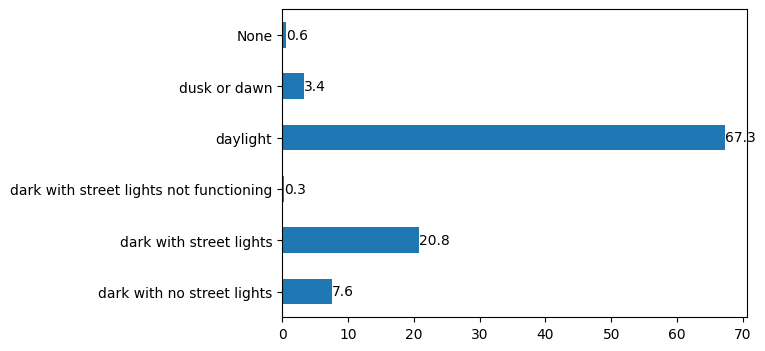

In [18]:
query = '''
WITH
lighting_count AS
    (SELECT lighting,
            COUNT(*)
     FROM collisions
     GROUP BY lighting)

SELECT *,
       count / SUM(count) OVER () * 100 as percent
FROM lighting_count
;'''
ax = pd.read_sql_query(sql=query, con=engine).plot(x='lighting', y='percent', kind='barh',
                                                       figsize=(6, 4), ylabel='', legend='');
ax.bar_label(ax.containers[0], fmt='%.1f');

Всего около 12% процентов ДТП произошло в темное время суток без работающих фонарей, почти 21% в темное время при фонарях и 67% в светлое время суток. Скорее всего, это связано с количеством машин на дорогах в разное время.

#### Как часто водитель не виноват в ДТП?

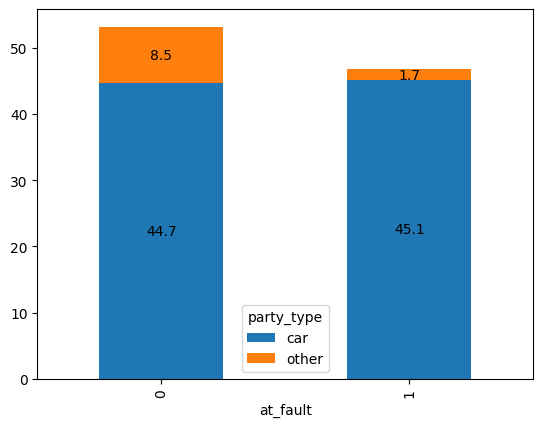

In [19]:
query = '''
WITH 
car_party AS (
    SELECT party_type,
           at_fault,
           COUNT(*)
    FROM parties
    WHERE party_type = 'car'
    GROUP BY party_type, at_fault
    UNION
    SELECT *, COUNT(*)
    FROM (SELECT 'other' AS party_type,
               at_fault
        FROM parties
        WHERE party_type != 'car') AS f
    GROUP BY party_type, at_fault)

SELECT *,
       count / SUM(count) OVER () * 100 AS percent
FROM car_party
;'''
ax = pd.read_sql_query(sql=query, con=engine).pivot(index='at_fault', columns='party_type', values='percent').plot(kind='bar', stacked=True);
ax.bar_label(ax.containers[0], fmt='%.1f', label_type='center'); ax.bar_label(ax.containers[1], fmt='%.1f', label_type='center');

Из 100% участников всех ДТП 44.7% водителей не были виноваты в аварии. 8.5% - это другие невиновные участники ДТП, вроде пешеходов, дорожных знаков и зданий. Да, в данных среди участников были знаки и здания - может, это просто ошибка, а может, в случае со знаками, они действительно могут быть виноваты, если установлены в неправильном месте?      
45.1% участников - водители, устроившие ДТП. Процент виновных и невиновных водителей близок - виновных больше всего на 1.6%.

## 4. Подготовка данных

Для обучения модели нужно выбрать признаки, на основе которых получится сделать предсказание.    

Предсказывать будем вероятность ДТП, когда водитель сел за руль и выбрал маршрут, значит, выбираем тип участника только `car` и известные в этот момент условия:
- тип дороги, наличие светофоров
- состояние дороги - обычная, скользкая или с ямами
- погода, освещение дороги
- состояние водителя
- возраст машины

Город и регион со своими особенностями дорог могут влиять на вероятность ДТП, но чтобы точно что-то предсказать, нужно строить отдельную модель для каждого города.     
Взятые из данных предыдущих ДТП причина аварии, тип нарушения, тип и серьезность столкновения не имеют смысла для прогноза аварии.

In [20]:
query = '''
WITH 
collision_filter AS
                (SELECT * FROM collisions 
                 WHERE EXTRACT('YEAR' FROM collision_date) = 2012
                       AND collision_damage != 'scratch'), 
party_filter AS 
            (SELECT * FROM parties
             WHERE party_type = 'car')
                
SELECT  cf.case_id,
        collision_time,
        CAST(EXTRACT('MONTH' FROM collision_date) AS int) AS collision_month, -- месяц 
        
        intersection,
        location_type,     -- тип дороги
        control_device,
        
        weather_1,         -- погодные условия
        lighting,
        road_surface,      -- состояние дороги
        road_condition_1,
        
        party_sobriety,    -- состояние водителя
        party_drug_physical, -- возраст машины
        vehicle_age,
        vehicle_type,
        
        at_fault           -- целевой признак
        
FROM collision_filter AS cf
JOIN party_filter AS pf ON cf.case_id = pf.case_id
JOIN vehicles AS vf ON pf.case_id = vf.case_id 
                    AND pf.party_number = vf.party_number
ORDER BY cf.case_id
;
'''

In [21]:
df = pd.read_sql_query(sql=query, con=engine)
df

,case_id,collision_time,collision_month,intersection,location_type,control_device,weather_1,lighting,road_surface,road_condition_1,party_sobriety,party_drug_physical,vehicle_age,vehicle_type,at_fault
0,5125160,07:40:00,3,1.0,None,none,cloudy,daylight,dry,other,had not been drinking,None,2.0,sedan,0
1,5173738,12:54:00,4,1.0,None,none,clear,daylight,dry,normal,had not been drinking,None,5.0,sedan,0
2,5269486,16:35:00,11,1.0,None,functioning,clear,daylight,dry,normal,had not been drinking,None,1.0,sedan,0
3,5319820,19:32:00,9,0.0,None,functioning,clear,dark with street lights,dry,normal,had not been drinking,None,4.0,sedan,0
4,5329109,13:15:00,11,1.0,None,functioning,clear,daylight,dry,normal,had not been drinking,None,6.0,coupe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5668337,07:55:00,6,0.0,highway,none,clear,daylight,dry,normal,had not been drinking,None,6.0,sedan,0
56244,5668348,20:29:00,5,1.0,None,functioning,clear,daylight,dry,normal,had not been drinking,None,3.0,sedan,0
56245,5668349,23:05:00,6,0.0,highway,none,clear,dark with street lights,dry,normal,had not been drinking,None,12.0,sedan,1
56246,5668352,12:01:00,5,1.0,ramp,functioning,clear,daylight,dry,normal,had not been drinking,None,3.0,sedan,0


Получился датафрейм с 56248 записями и 15 столбцами. Столбец `case_id` нужен был для объединения таблиц и теперь его можно убрать.

In [22]:
df = df.drop('case_id', axis=1)
display(df.info())
for n in df.columns:
    display(df[n].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   collision_time       56160 non-null  object 
 1   collision_month      56248 non-null  int64  
 2   intersection         56073 non-null  float64
 3   location_type        25932 non-null  object 
 4   control_device       56033 non-null  object 
 5   weather_1            56080 non-null  object 
 6   lighting             56094 non-null  object 
 7   road_surface         55900 non-null  object 
 8   road_condition_1     55999 non-null  object 
 9   party_sobriety       55376 non-null  object 
 10  party_drug_physical  2857 non-null   object 
 11  vehicle_age          54554 non-null  float64
 12  vehicle_type         56248 non-null  object 
 13  at_fault             56248 non-null  int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 6.0+ MB


None

collision_time
15:00:00    413
15:30:00    362
16:00:00    342
18:00:00    317
15:20:00    302
           ... 
03:02:00      1
04:34:00      1
06:23:00      1
05:54:00      1
04:04:00      1
Name: count, Length: 1435, dtype: int64

collision_month
3     11511
4     10865
1     10789
2     10331
5      9683
6      1308
8       374
9       342
7       327
11      264
10      262
12      192
Name: count, dtype: int64

intersection
0.0    43651
1.0    12422
Name: count, dtype: int64

location_type
highway         21323
ramp             3267
intersection     1342
Name: count, dtype: int64

control_device
none               37578
functioning        18310
not functioning      116
obscured              29
Name: count, dtype: int64

weather_1
clear      45092
cloudy      8427
raining     2178
fog          181
snowing      157
other         34
wind          11
Name: count, dtype: int64

lighting
daylight                                   38064
dark with street lights                    11017
dark with no street lights                  5109
dusk or dawn                                1769
dark with street lights not functioning      135
Name: count, dtype: int64

road_surface
dry         50242
wet          5258
snowy         357
slippery       43
Name: count, dtype: int64

road_condition_1
normal            54066
construction       1003
obstruction         248
other               228
holes               222
loose material      128
reduced width        72
flooded              32
Name: count, dtype: int64

party_sobriety
had not been drinking                     48577
had been drinking, under influence         4475
impairment unknown                         1238
had been drinking, not under influence      575
had been drinking, impairment unknown       261
not applicable                              250
Name: count, dtype: int64

party_drug_physical
G                        1238
under drug influence      857
sleepy/fatigued           390
not applicable            250
impairment - physical     122
Name: count, dtype: int64

vehicle_age
3.0      11012
4.0       7157
2.0       6048
5.0       5565
6.0       3940
7.0       3838
8.0       3509
0.0       3087
9.0       2770
1.0       2545
10.0      1942
11.0      1380
12.0       879
13.0       551
14.0       282
15.0        37
16.0         6
17.0         3
161.0        2
19.0         1
Name: count, dtype: int64

vehicle_type
sedan    37180
coupe    19064
other        4
Name: count, dtype: int64

at_fault
1    28373
0    27875
Name: count, dtype: int64

В столбце с возрастом машин есть пропуски - заполнить их каким-либо логичным значением не получится - удалим их.     
Среди машин есть всего несколько возрастом больше 15 лет, а также две машины возрастом 161 год. Может, вместо этого должно было быть 16? Заменим возраст, больше чем 15 лет на ровно 15:

In [23]:
df = df.dropna(subset=['vehicle_age']).reset_index(drop=True)
df.loc[df['vehicle_age'] > 15, 'vehicle_age'] = 15
df['vehicle_age'].value_counts()

vehicle_age
3.0     11012
4.0      7157
2.0      6048
5.0      5565
6.0      3940
7.0      3838
8.0      3509
0.0      3087
9.0      2770
1.0      2545
10.0     1942
11.0     1380
12.0      879
13.0      551
14.0      282
15.0       49
Name: count, dtype: int64

В столбцах с перекрестками и с типом дороги значения не всегда совпадали - там, где в одном столбце было указано шоссе, в другом мог стоять перекресток. Возьмем за основу столбец `location_type` и заполним пропуски значениями из `intersection`. Оставшиеся пропуски заменим на `highway`, как самое часто встречающееся значение:

In [24]:
df.loc[(df['intersection'] == 1) & (df['location_type'].isna()), 'location_type'] = 'intersection'
df.loc[(df['intersection'] == 0) & (df['location_type'].isna()), 'location_type'] = 'highway'
df['location_type'] = df['location_type'].fillna('highway')
df = df.drop('intersection', axis=1)
df['location_type'].unique()

array(['intersection', 'highway', 'ramp'], dtype=object)

Заменим редко встречающиеся значения и заполним пропуски в оставшихся столбцах:

In [25]:
df['control_device'] = df['control_device'].replace([None], ['none'])# 'not functioning', 'obscured'],\
#                                                    ['none', 'none', 'none'])
df['weather_1'] = df['weather_1'].replace([None], ['clear'])#['wind', 'fog', 'snowing', None],\
#                                          ['other', 'other', 'other', 'other'])
df['lighting'] = df['lighting'].replace([None], ['dark with no street lights'])#['dark with street lights not functioning', None],\
#                                        ['dark with no street lights', 'dark with no street lights'])
df['road_surface'] = df['road_surface'].replace([None], ['dry'])#[None, 'slippery'],\
#                                                ['dry', 'wet'])
df['road_condition_1'] = df['road_condition_1'].fillna('normal')
#df.loc[df['road_condition_1'] != 'normal', 'road_condition_1'] = 'other'
df['vehicle_type'] = df['vehicle_type'].replace([None, 'other'], ['none', 'coupe'])

In [26]:
df['party_sobriety'] = df['party_sobriety'].replace([None], ['had not been drinking'])#[None, 'not applicable'],\
#                                                    ['had not been drinking', 'impairment unknown'])
df['party_drug_physical'] = df['party_drug_physical'].replace(['G', None],\
                                                              ['unknown', 'no impairment'])

In [27]:
df['collision_time'] = df['collision_time'].fillna(df['collision_time'].mode()[0])
df['collision_time'] = df['collision_time'].apply(lambda x: x.hour * 60 + x.minute)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   collision_time       54554 non-null  int64  
 1   collision_month      54554 non-null  int64  
 2   location_type        54554 non-null  object 
 3   control_device       54554 non-null  object 
 4   weather_1            54554 non-null  object 
 5   lighting             54554 non-null  object 
 6   road_surface         54554 non-null  object 
 7   road_condition_1     54554 non-null  object 
 8   party_sobriety       54554 non-null  object 
 9   party_drug_physical  54554 non-null  object 
 10  vehicle_age          54554 non-null  float64
 11  vehicle_type         54554 non-null  object 
 12  at_fault             54554 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 5.4+ MB


Все пропуски заполнены. В данных осталось 54554 записей, 12 признаков и 1 целевой.

### Подготовка выборок

Разделим данные на тренировочную и тестовую выборки:

In [30]:
features = df.drop(['at_fault'], axis=1)
target = df['at_fault']

X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25, shuffle=True, stratify=target, random_state=SEED)

В данных есть категориальные и числовые признаки. Выберем признаки для ОНЕ и порядкового кодирования, а также масштабирования:

In [31]:
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
ordinal_features = X_train.select_dtypes(include='int64').columns.to_list()
ord_cat_features = X_train.select_dtypes(exclude='float64').columns.to_list()
num_features = X_train.select_dtypes(include='float64').columns.to_list()

## 5. Обучение моделей

Для того, чтобы строить модели, осталось определиться с метрикой для оценки их качества. Задача модели - не пропустить потенциальные аварии, при этом не предсказывая их постоянно, на всякий случай. Чтобы оценить способность модели предсказывать целевое действие, можно использовать метрику recall (полнота). При этом, чтобы среди предсказаний было как можно меньше ложно-положительных, можно использовать precision (точность). По отдельности эти метрики плохо показывают качество, но их можно объединить в одну метрику - F-beta меру. Это среднее гармоническое полноты и точности, которое достигает максимума при этих двух метриках, равных единице, и близко к нулю, когда одна из них близка к нулю. Также для оценки качества можно вывести на график кривую полноты и точности, показывающую компромисс между ними - чем ближе к единице значение одной метрики, тем ближе к нулю может быть значение другой.       
На графике ниже показан пример отношения полноты и точности. Пунктирная линия - это результат случайной модели, просто угадывающей значения. Синяя линия показывает, насколько точно были предсказаны положительные значения, и насколько много. Когда модель предсказывает положительный класс точно, но не часто, кривая будет расположена большей частью слева вверху, и будет снижаться к правому нижнему углу. Когда часто, но неточно, кривая будет высоко в правой части и низко в левой. Обычно такой график должен сходиться к правому верхнему углу, чем лучше модель, тем ближе. Также на графике указано значение АР - средняя точность модели.

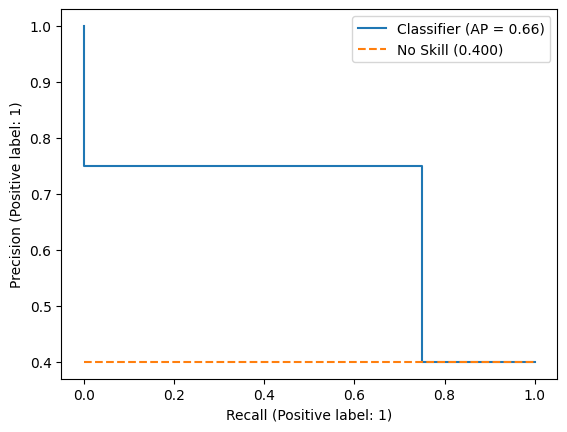

In [32]:
a = [1, 0, 0, 1, 1, 0, 0, 0, 1, 0]
b = [1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
PrecisionRecallDisplay.from_predictions(a, b)
no_skill = 4 / 10
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ({no_skill:.3f})')
plt.legend(loc='upper right');

Дальше можно написать функцию для обучения моделей. Она кодирует выборки, проводит подбор гиперпараметров и кросс-валидацию, а также выводит метрики лучшей модели. На вход ей нужна модель, сетка гиперпараметров, тренировочная выборка и набор названий признаков для кодирования их определенным способом. Метрика качества - F-beta.

In [33]:
fbeta = make_scorer(fbeta_score, beta=2)

In [34]:
def pipe_validate(model, param_grid, X_train, y_train, scoring={'fbeta': fbeta, 'AP':'average_precision'},\
                              ohe_features=ohe_features, ordinal_features=ordinal_features, num_features=num_features):
    transformer = make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
        (StandardScaler(), num_features),
        remainder='passthrough',
        verbose_feature_names_out=False)
    transformer.fit(X_train);

    pipe = make_pipeline(transformer, model)
    search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid,
                          scoring=scoring, verbose=1, random_state=SEED, refit='fbeta')
    search.fit(X_train, y_train)
    
    print(f'best_score: {search.best_score_}')
    print(f'best_params: {search.best_params_}')
    PrecisionRecallDisplay.from_estimator(search, X_train, y_train)
    no_skill = len(y_train[y_train==1]) / len(y_train)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ({no_skill:.3f})')
    plt.legend(loc='upper right')
    return search

Также создадим список, в который будут занесены результаты обучения моделей:

In [35]:
stat_table = []

### LogisticRegression

Первая модель - логистическая регрессия:

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best_score: 0.5189859420042617
best_params: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l2'}
CPU times: total: 12.9 s
Wall time: 12.9 s


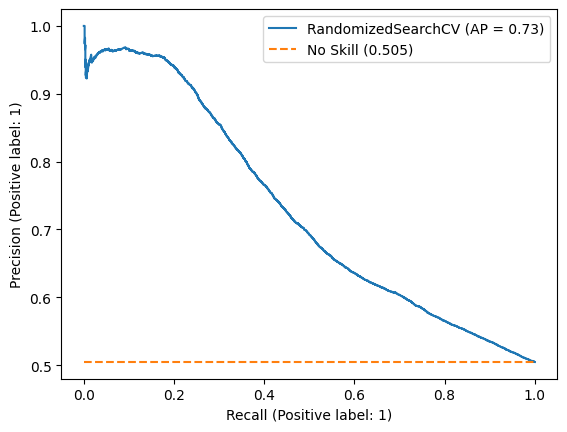

In [36]:
%%time

logreg = LogisticRegression(random_state=SEED)

param_log = {'logisticregression__penalty': ['l1', 'l2'],
             'logisticregression__solver': ['liblinear']}

res_log = pipe_validate(logreg, param_log, X_train, y_train);

In [37]:
stat_table.append(['LogisticRegression', res_log.best_score_,\
                   res_log.cv_results_['mean_test_AP'][res_log.best_index_]])

Лучшее значение F-beta на валидации - 0.52. Средняя точность при этом равна 0.73. Похоже, модель часто предсказывает отрицательный класс и редко положительный.

### RandomForest

Следующий - случайный лес:

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score: 0.5464472861262537
best_params: {'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_depth': 11}
CPU times: total: 50.2 s
Wall time: 50.6 s


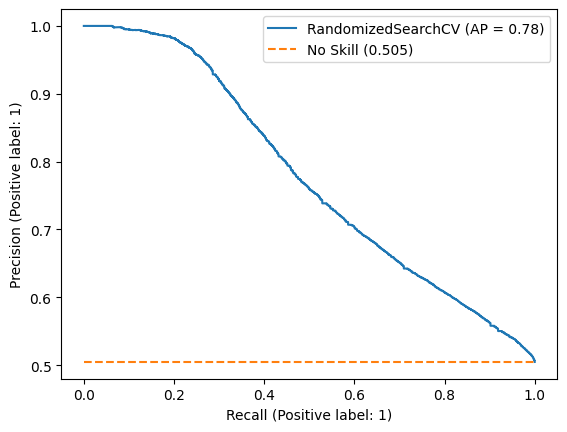

In [38]:
%%time

forest = RandomForestClassifier(random_state=SEED)

param_rf = {'randomforestclassifier__n_estimators': range(10, 110, 20),
            'randomforestclassifier__max_depth': range(3, 12),
            'randomforestclassifier__min_samples_split': (2, 3, 4)}

res_forest = pipe_validate(forest, param_rf, X_train, y_train, ohe_features=[], ordinal_features=ord_cat_features);

In [39]:
stat_table.append(['RandomForestClassifier', res_forest.best_score_,\
                   res_forest.cv_results_['mean_test_AP'][res_forest.best_index_]])

Лес немного лучше, чем случайная модель. F-beta равна 0.54, АР также чуть больше - 0.78. График выглядит таким же наклоненным, но уже гораздо более плавным.

### SGD

SGD - или стохастический градиентный спуск - это всего лишь другой способ обучить модель. В основе этого классификатора лежат линейные модели:

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best_score: 0.5257356323633723
best_params: {'sgdclassifier__loss': 'hinge', 'sgdclassifier__alpha': 0.1}
CPU times: total: 17.8 s
Wall time: 17.8 s


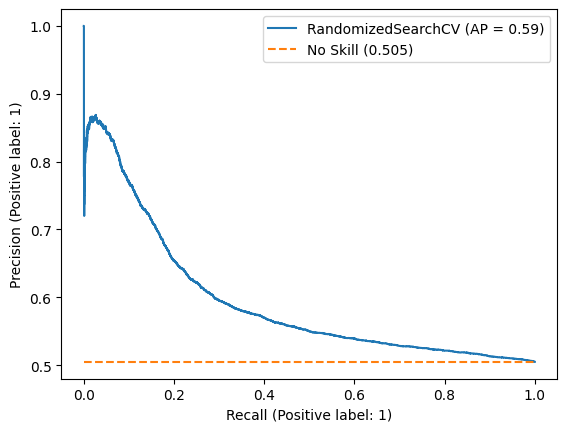

In [40]:
%%time

sgd = SGDClassifier(max_iter=250, early_stopping=True, random_state=SEED)

param_sgd = {'sgdclassifier__loss': ['hinge', 'modified_huber'],
             'sgdclassifier__alpha': (0.0001, 0.001, 0.01, 0.1)}

res_sgd = pipe_validate(sgd, param_sgd, X_train, y_train);

In [41]:
stat_table.append(['SGDClassifier', res_sgd.best_score_,\
                   res_sgd.cv_results_['mean_test_AP'][res_log.best_index_]])

Результат вышел немного лучше лог. регрессии - F-бета равна 0.525. Средняя точность всего 0.59, график в начале резко дернулся вниз - выглядит странно.

### CatBoost

В данных большая часть признаков - категориальные. Для работы с ними можно попробовать CatBoost:

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score: 0.5716214025296408
best_params: {'catboostclassifier__learning_rate': 0.7, 'catboostclassifier__l2_leaf_reg': 0.3, 'catboostclassifier__depth': 9}
CPU times: total: 2min 46s
Wall time: 1min 23s


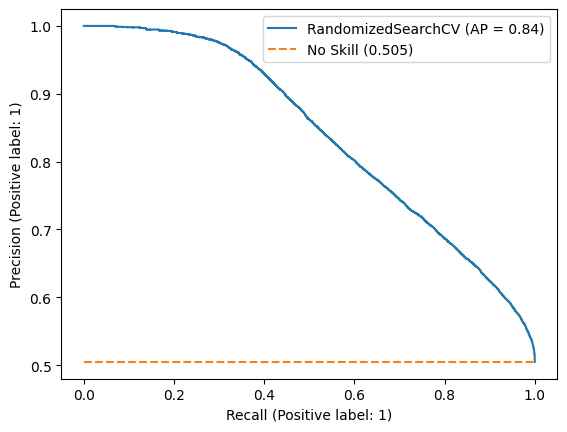

In [42]:
%%time

cat = CatBoostClassifier(iterations=100, early_stopping_rounds=10, random_seed=SEED, logging_level='Silent')

param_cat = {'catboostclassifier__learning_rate': [0.1, 0.3, 0.5, 0.7],
             'catboostclassifier__depth': range(3, 12, 3),
             'catboostclassifier__l2_leaf_reg': [0.1, 0.3, 0.5]}

res_cat = pipe_validate(cat, param_cat, X_train, y_train, ohe_features=[], ordinal_features=ord_cat_features);

In [43]:
stat_table.append(['CatBoostClassifier', res_cat.best_score_,\
                   res_cat.cv_results_['mean_test_AP'][res_log.best_index_]])

F-beta мера получилась лучше, чем у других моделей - 0.57. Средняя точность на графике - 0.84. Сама кривая выглядит более выгнутой, чем у леса, что очень хорошо.

Построим таблицу для сравнения:

In [44]:
pd.DataFrame(stat_table, columns=['model', 'FBeta', 'AP']).style.background_gradient(cmap='Blues')

,model,FBeta,AP
0,LogisticRegression,0.518986,0.726782
1,RandomForestClassifier,0.546447,0.734137
2,SGDClassifier,0.525736,0.563760
3,CatBoostClassifier,0.571621,0.737444


Случайный лес и Катбуст выглядят достойными конкурентами по AP, но раз главная метрика качества у нас F-beta, то лучшей считаем Катбуст.

## 6. Тест модели

Протестируем лучшую модель. Сначала подготовим данные:

In [45]:
transformer = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_cat_features),
    (StandardScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False)

transformer.fit(X_train);

X_train_enc = pd.DataFrame(
    transformer.transform(X_train),
    columns=transformer.get_feature_names_out())

X_test_enc = pd.DataFrame(
    transformer.transform(X_test),
    columns=transformer.get_feature_names_out())

X_test_enc.head(3)

,collision_time,collision_month,location_type,control_device,weather_1,lighting,road_surface,road_condition_1,party_sobriety,party_drug_physical,vehicle_type,vehicle_age
0,505.0,0.0,0.0,1.0,0.0,3.0,0.0,4.0,2.0,1.0,1.0,-0.592622
1,988.0,3.0,0.0,1.0,0.0,3.0,0.0,4.0,3.0,1.0,1.0,0.700247
2,380.0,9.0,1.0,0.0,0.0,4.0,0.0,4.0,3.0,1.0,0.0,0.700247


0.5950296967802438


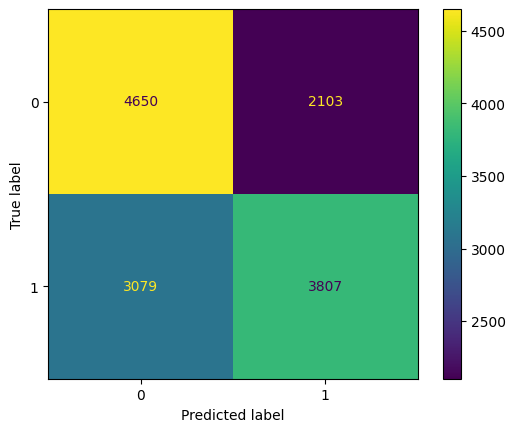

In [46]:
res_cat.best_estimator_.fit(X_train_enc, y_train)
preds = res_cat.best_estimator_.predict(X_test_enc)

print(f1_score(y_test, preds))
ConfusionMatrixDisplay.from_predictions(y_test, preds);

На тестовой выборке F-beta вышла чуть больше, чем на тренировочной - 0.59. Матрица ошибок выглядит плохо: правильно определять обычные поездки модель еще хоть как-то может, а вот ДТП она предсказывает почти что подкидывая монетку.

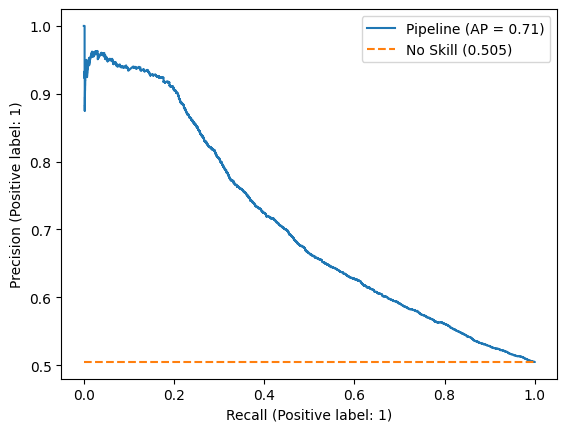

In [47]:
PrecisionRecallDisplay.from_estimator(res_cat.best_estimator_, X_test_enc, y_test)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ({no_skill:.3f})')
plt.legend(loc='upper right');

График точности и полноты выглядит хуже, чем на тренировке. Средняя точность 0.71.

In [48]:
for n in range(len(res_cat.best_estimator_.feature_names_in_)):
    print(res_cat.best_estimator_.feature_names_in_[n], ": ",\
          res_cat.best_estimator_.steps[1][1].feature_importances_[n])

collision_time :  16.85593668150313
collision_month :  11.074308233242016
location_type :  6.920212406806244
control_device :  6.509164307286018
weather_1 :  4.090796145356604
lighting :  5.321653961986372
road_surface :  2.7082332276088246
road_condition_1 :  1.6803409953950283
party_sobriety :  14.418972329488378
party_drug_physical :  4.864942565393117
vehicle_type :  9.054819995638463
vehicle_age :  16.500619150295822


C важностью признаков модель справилась неплохо. Из анализа было ясно, что трезвость водителя очень сильно влияет на риск ДТП. Здесь этому признаку присвоено 14 единиц. Кроме этого очень важно было состояние водителя (не сонный ли он), но модель посчитала это не таким вадным фактором. Возраст машины также немного влиял на риск ДТП, здесь он важен. Из всех изученных признаков только у этих была заметная зависимость с целевым признаком. Также модель посчитала очень важным время аварии, до часов и минут, а не просто освещенность дороги.

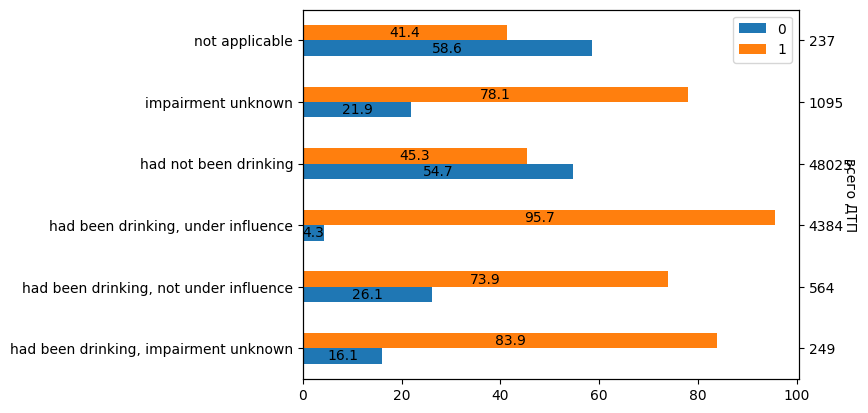

In [49]:
stat = df.pivot_table(index=['party_sobriety', 'at_fault'],\
                      values='collision_month', aggfunc='count').reset_index()
sums = stat.groupby(['party_sobriety']).sum()['collision_month'].values
percent = [stat[stat['at_fault']==0]['collision_month'].values,\
           stat[stat['at_fault']==1]['collision_month'].values] / sums * 100
pdf = pd.DataFrame(data=percent, columns=stat['party_sobriety'].unique(), index=['0', '1']).T
ax = pdf.plot(kind='barh');
ax.bar_label(ax.containers[0], fmt='%.1f', label_type='center');
ax.bar_label(ax.containers[1], fmt='%.1f', label_type='center');
ax2 = ax.twinx(); ax2.set_ylim(ax.get_ylim()); ax2.set_ylabel('всего ДТП', rotation=-90)
ax2.set_yticks(np.arange(len(sums)), labels=sums);

График выше показывает зависимость целевой переменной от самого важного для модели признака - трезвости водителя.    
Количественно трезвые водители создали больше ДТП, чем все нетрезвые вместе. Если смотреть только на количество можно решить, что у трезвых водителей больше риск попасть в аварию, что конечно же не так. Если смотреть на процент виновных водителей в каждой категории, то среди трезвых виновных всего 45.3% - это не просто самый низкий процент среди всех, этот процент также показывает, что трезвые водители чаще были невиновны, им просто не повезло и кто-то другой врезался в них. Например, кто-то не совсем трезвый - у таких водителей процент виновных выше 71.5. Те, кто нетрезв и по анализу и по состоянию, создают ДТП в 95.7% случаев - всего 4.3% попали в аварию случайно.

В этих данных о ДТП нетрезвых водителей не так много, всего чуть больше 6.6 тыс. Несмотря на это, именно их нельзя пропустить и допустить к вождению - они не только с большей вероятностью создадут опасную ситуацию, но также, как было видно из статистического анализа, с большей вероятностью нанесут серьезный ущерб участникам ДТП.     
Чтобы не допустить нетрезвого водителя за руль можно перед поездкой оценить его состояние анализатором алкогольного опьянения. Чтобы убедиться, что в анализатор дышит именно водитель, можно добавить камеру, направленную на водительское место. Камера также может помочь определить степень сонливости водителя, а это немаловажный фактор.

## 7. Вывод

С текущими данными из базы у моделей плохо получается предсказывать ДТП. Даже у лучшей модели, "заточенной" под работу с категориальными признаками, F-beta мера равна всего 0.59. Модель неплохо справляется с предсказанием не-аварий, но аварии предсказывает плохо - из них правильно отмечено всего 55%.       
Похоже, что создать систему оценки риска ДТП будет трудно. Для этого нужно собирать данные, которые предшествовали аварии.      
Для улучшения точности можно собрать данные о плотности трафика. Если узнать, как много машин было на дороге во время аварии, скорее всего, невозможно, то можно хотя бы узнать, насколько это обычно оживленная дорога и попытаться предсказать на основе этого. Также можно попробовать собрать данные о стаже водителя.       
Данные о погоде, состоянии дороги, о перекрестках, развилках и нерабочих светофорах лучше оставить водителю - предупредить его о возможных трудностях на выбранном маршруте будет достаточно. Если и пробовать предсказывать ДТП по погоде и освещенности, то нужно собрать гораздо больше информации об авариях в плохих условиях, вроде темноты, мокрой дороги, гололедицы, метели и др. В текущих данных их слишком мало для уверенных предсказаний.